## Imports

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (37.4 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

### Import Packages

In [17]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

import pandas_datareader.naver as web_naver

from sklearn.cluster import KMeans, AgglomerativeClustering,AffinityPropagation, DBSCAN
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold


import matplotlib.ticker as ticker
from itertools import cycle

In [19]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
idx = pd.IndexSlice
sns.set(font='NanumBarunGothic',
       style='darkgrid')
plt.rc('font', family='NanumBarunGothic') # 폰트 지정
sns.set_style('whitegrid')
np.random.seed(42)

### Import data

In [21]:
krx100 = pd.read_csv('KRX100.csv', encoding='cp949')
krx100.head()

,종목코드,종목명,종가,대비,등락률,상장시가총액
0,5930,삼성전자,60000,2500,4.35,358186953.0
1,373220,LG에너지솔루션,400000,500,0.13,93600000.0
2,660,SK하이닉스,98700,4700,5.00,71853833.0
3,207940,삼성바이오로직스,817000,-8000,-0.97,58149158.0
4,5380,현대차,183500,1000,0.55,39208112.0


In [23]:
krx300 = pd.read_csv('KRX300.csv', encoding='cp949')
krx300.head()

,종목코드,종목명,종가,대비,등락률,상장시가총액
0,5930,삼성전자,60000,2500,4.35,358186953.0
1,660,SK하이닉스,98700,4700,5.00,71853833.0
2,207940,삼성바이오로직스,817000,-8000,-0.97,58149158.0
3,5380,현대차,183500,1000,0.55,39208112.0
4,35420,NAVER,231000,-2500,-1.07,37895339.0


In [25]:
kospi200 = pd.read_csv('KOSPI200.csv', encoding='cp949')
kospi200.head()

,종목코드,종목명,종가,대비,등락률,상장시가총액
0,5930,삼성전자,60000,2500,4.35,358186953.0
1,373220,LG에너지솔루션,400000,500,0.13,93600000.0
2,660,SK하이닉스,98700,4700,5.00,71853833.0
3,207940,삼성바이오로직스,817000,-8000,-0.97,58149158.0
4,5380,현대차,183500,1000,0.55,39208112.0


In [27]:
kosdaq150 = pd.read_csv('KOSDAQ150.csv', encoding='cp949')
kosdaq150.head()

,종목코드,종목명,종가,대비,등락률,상장시가총액
0,91990,셀트리온헬스케어,70500,-800,-1.12,11149919.0
1,247540,에코프로비엠,111500,-5500,-4.70,10904850.0
2,66970,엘앤에프,207500,-5500,-2.58,7455395.0
3,28300,HLB,42800,250,0.59,4574581.0
4,293490,카카오게임즈,49400,-2100,-4.08,3887740.0


In [29]:
start = datetime.datetime(2012,1,1)
end = datetime.datetime(2021,1,1)
#dataset = pd.concat([kospi200, kosdaq150], axis=0)
#dataset = krx100
dataset = krx300

In [35]:
def import_price_data(start, end, dataset):
    dictionary = {}
    code_list = dataset['종목코드'].tolist()
    name_list = dataset['종목명'].tolist()
    for i in tqdm(range(len(code_list))):
        code = str(code_list[i]).zfill(6)
        name = name_list[i]
        df = web_naver.NaverDailyReader(symbols=code, start=start, end=end, adjust_price=True).read()
        adj_close = df.Close
        dictionary[name] = adj_close
    data = pd.DataFrame(dictionary)
    data = data.astype('float')
    return data

In [36]:
df = import_price_data(start, end, dataset)

100%|██████████| 300/300 [07:48<00:00,  1.56s/it]


In [37]:
# 5% 이상의 결측치가 존재하면 그 종목은 사용하지 않기로 한다.
def dropna_percent(percentage, dataset):
    print('결측치 존재 여부: ', dataset.isnull().values.any())
    missing_fraction = dataset.isnull().mean().sort_values(ascending=False)
    drop_list = sorted(list(missing_fraction[missing_fraction > percentage].index))
    new_df = dataset.drop(labels=drop_list, axis=1)
    print(f"제거한 column의 수는 {len(drop_list)}개 입니다.")
    return new_df

In [38]:
df = dropna_percent(0.05, df)

결측치 존재 여부:  True
제거한 column의 수는 93개 입니다.


In [39]:
df = df.fillna(method='ffill')
df = df.fillna(method='bfill')
print(df.shape)
print('결측치 존재 여부: ', df.isnull().values.any())

(2215, 207)
결측치 존재 여부:  False


In [40]:
train = df[df.index < '2019-01-01']
test = df[df.index > '2019-01-01']

## Data Transformation and Use Clustering Algorithm

### Data Transformation

In [41]:
returns = train.pct_change().mean() * 252
returns = pd.DataFrame(returns)
returns.columns = ['Returns']
returns['Volatility'] = train.pct_change().std() * np.sqrt(252)
data=returns

In [42]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(data)
rescaledDataset = pd.DataFrame(scaler.fit_transform(data),columns = data.columns, index = data.index)
# summarize transformed data
rescaledDataset.head(2)
X=rescaledDataset
X.head(2)

,Returns,Volatility
삼성전자,-0.047510,-1.153056
SK하이닉스,0.383862,-0.456163


### K-means

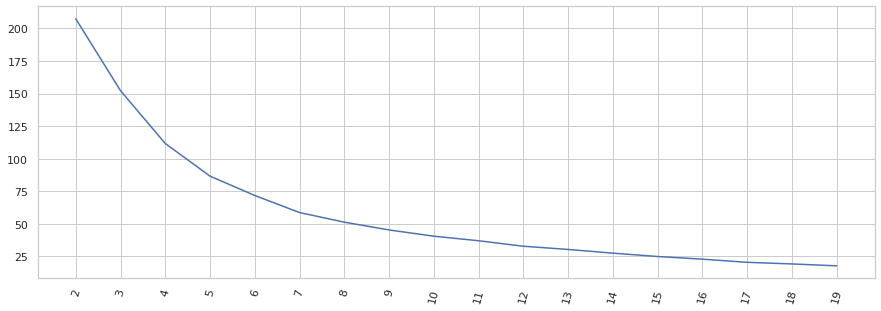

In [43]:
# 군집 내 SSE 값
distorsions = []
max_loop=20
for k in range(2, max_loop):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), distorsions)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)

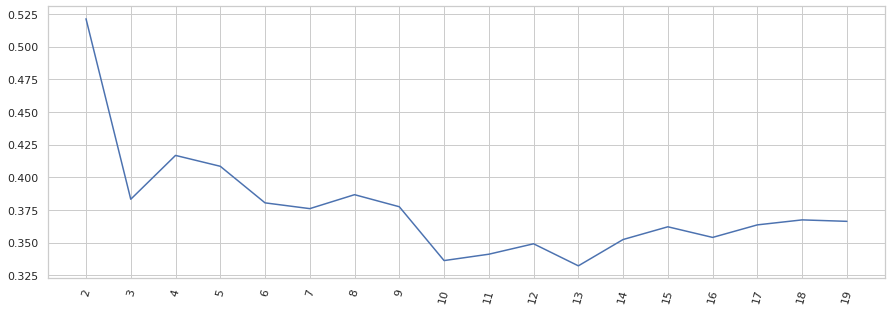

In [44]:
# 실루엣 계수
from sklearn import metrics

silhouette_score = []
for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10)
        kmeans.fit(X)        
        silhouette_score.append(metrics.silhouette_score(X, kmeans.labels_, random_state=10))
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), silhouette_score)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)

In [45]:
nclust=4

k_means = cluster.KMeans(n_clusters=nclust)
k_means.fit(X)

KMeans(n_clusters=4)

In [46]:
target_labels = k_means.predict(X)

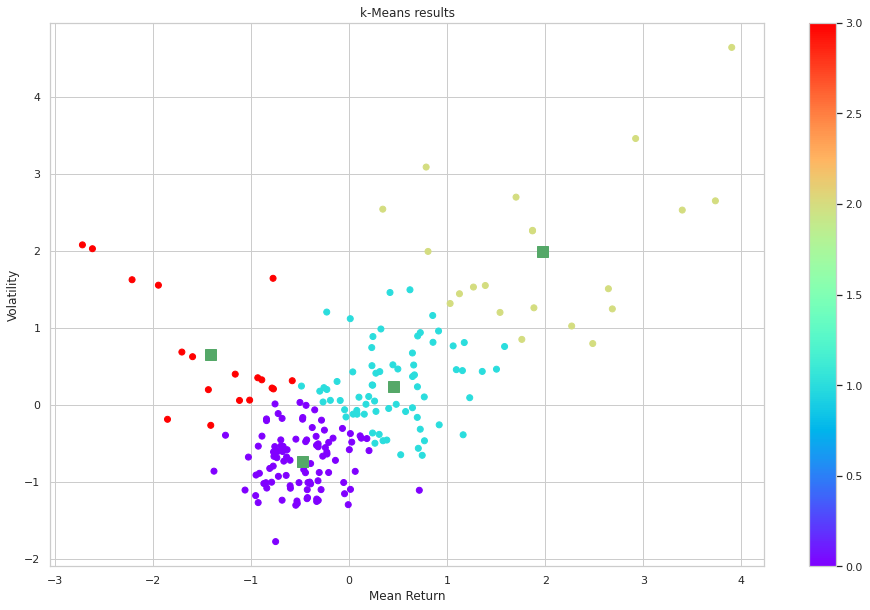

In [47]:
centroids = k_means.cluster_centers_
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c = k_means.labels_, cmap ="rainbow", label = X.index)
ax.set_title('k-Means results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11)

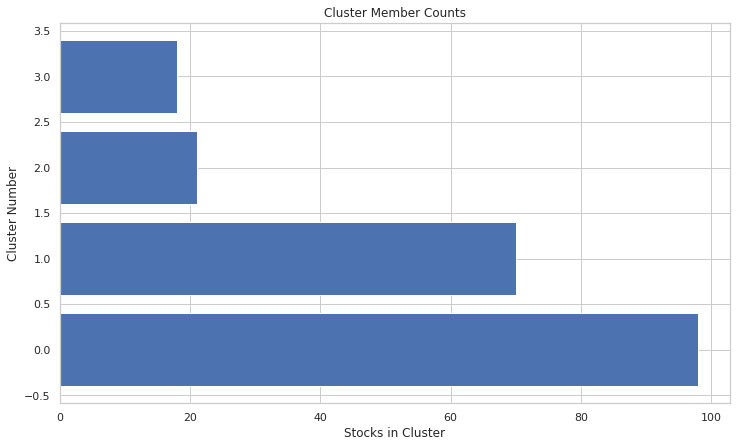

In [48]:
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]

plt.figure(figsize=(12,7))
plt.barh(
    range(len(clustered_series.value_counts())), # cluster labels, y axis
    clustered_series.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.show()

### 계층적 군집화

In [49]:
from scipy.cluster.hierarchy import dendrogram, linkage, ward

#Calulate linkage
Z= linkage(X, method='ward')
Z[0]

array([1.10000000e+02, 1.53000000e+02, 6.28373888e-03, 2.00000000e+00])

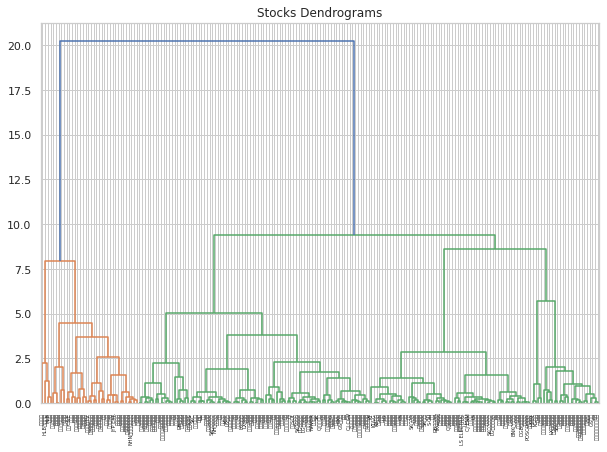

In [50]:
#Plot Dendogram
plt.figure(figsize=(10, 7))
plt.title("Stocks Dendrograms")
dendrogram(Z,labels = X.index)
plt.show()

In [51]:
distance_threshold = 7
clusters = fcluster(Z, distance_threshold, criterion='distance')
chosen_clusters = pd.DataFrame(data=clusters, columns=['cluster'])
chosen_clusters['cluster'].unique()

array([4, 3, 2, 5, 1], dtype=int32)

In [52]:
nclust = 5
hc = AgglomerativeClustering(n_clusters=nclust, affinity = 'euclidean', linkage = 'ward')
clust_labels1 = hc.fit_predict(X)

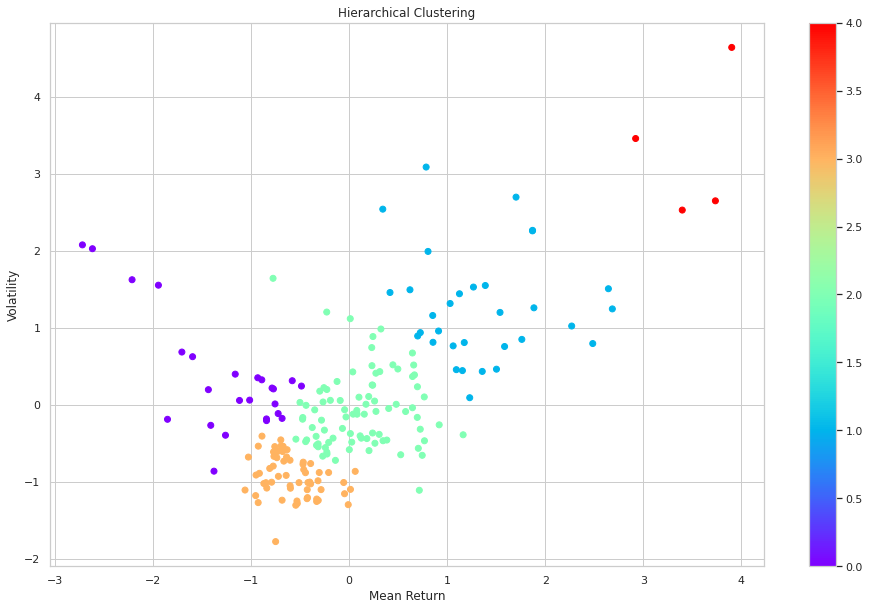

In [53]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c =clust_labels1, cmap ="rainbow")
ax.set_title('Hierarchical Clustering')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

### Affinity Propagation

In [54]:
ap = AffinityPropagation()
ap.fit(X)
clust_labels2 = ap.predict(X)

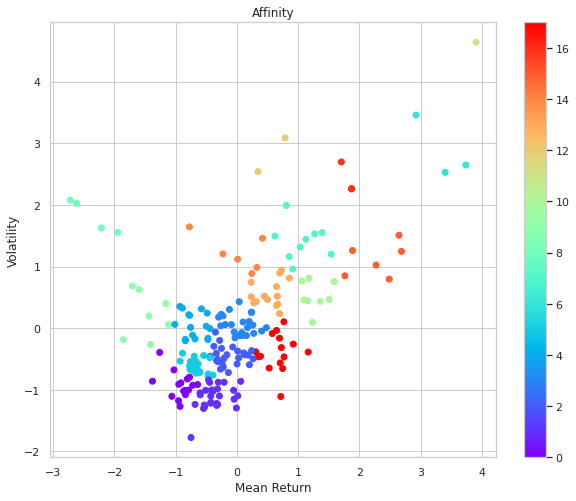

In [55]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c =clust_labels2, cmap ="rainbow")
ax.set_title('Affinity')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

In [56]:
cluster_centers_indices = ap.cluster_centers_indices_
labels = ap.labels_

Estimated number of clusters: 18


<Figure size 432x288 with 0 Axes>

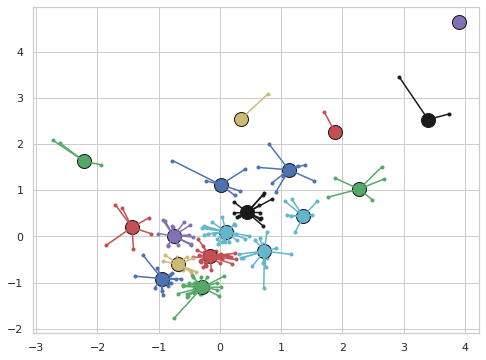

In [57]:
no_clusters = len(cluster_centers_indices)
print('Estimated number of clusters: %d' % no_clusters)

X_temp=np.asarray(X)
plt.close('all')
plt.figure(1)
plt.clf()

fig = plt.figure(figsize=(8,6))
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(no_clusters), colors):
    class_members = labels == k
    cluster_center = X_temp[cluster_centers_indices[k]]
    plt.plot(X_temp[class_members, 0], X_temp[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)
    for x in X_temp[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.show()

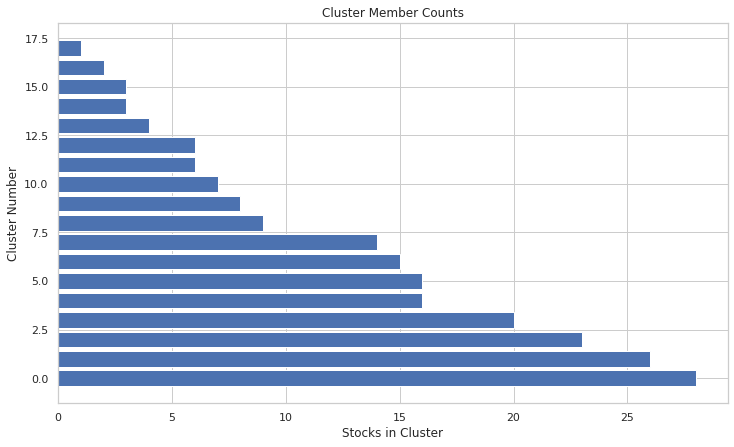

In [58]:
clustered_series_ap = pd.Series(index=X.index, data=ap.labels_.flatten())
clustered_series_all_ap = pd.Series(index=X.index, data=ap.labels_.flatten())
clustered_series_ap = clustered_series_ap[clustered_series != -1]

plt.figure(figsize=(12,7))
plt.barh(
    range(len(clustered_series_ap.value_counts())), # cluster labels, y axis
    clustered_series_ap.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.show()

### 군집화 평가

In [59]:
from sklearn import metrics
print("km", metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))
print("hc", metrics.silhouette_score(X, hc.fit_predict(X), metric='euclidean'))
print("ap", metrics.silhouette_score(X, ap.labels_, metric='euclidean'))

km 0.4167028902329474
hc 0.36250821399669386
ap 0.3559792558283614


## Finding pair

In [60]:
# all stock with its cluster label (including -1)
clustered_series = pd.Series(index=X.index, data=k_means.fit_predict(X).flatten())
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=X.index, data=k_means.fit_predict(X).flatten())
clustered_series = clustered_series[clustered_series != -1]

In [61]:
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print ("Clusters formed: %d" % len(ticker_count_reduced))
print ("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

Clusters formed: 4
Pairs to evaluate: 15120


In [62]:
def find_cointegrated_pairs(data, significance=0.05):
    # This function is from https://www.quantopian.com/lectures/introduction-to-pairs-trading
    n = data.shape[1]    
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(1):
        for j in range(i+1, n):
            S1 = data[keys[i]]            
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [63]:
from statsmodels.tsa.stattools import coint
cluster_dict = {}
for i, which_clust in enumerate(ticker_count_reduced.index):
    tickers = clustered_series[clustered_series == which_clust].index   
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
        train[tickers]
    )
    cluster_dict[which_clust] = {}
    cluster_dict[which_clust]['score_matrix'] = score_matrix
    cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[which_clust]['pairs'] = pairs

In [64]:
pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])

In [65]:
print ("Number of pairs found : %d" % len(pairs))
print ("In those pairs, there are %d unique tickers." % len(np.unique(pairs)))

Number of pairs found : 9
In those pairs, there are 13 unique tickers.


In [66]:
print(len(pairs))
print(pairs)

9
[('삼성전자', 'KB금융'), ('삼성전자', '현대해상'), ('삼성전자', '에스에프에이'), ('SK하이닉스', '한미반도체'), ('셀트리온', 'HLB'), ('셀트리온', 'HLB생명과학'), ('셀트리온', '오스코텍'), ('두산에너빌리티', '삼성중공업'), ('두산에너빌리티', 'SFA반도체')]


## Perform EDA and Cointegration test for Selected pair

### Choose one pair

In [67]:
asset1 = '삼성전자'
asset2 = 'KB금융'

In [68]:
pair1 = pd.DataFrame()
pair1[asset1] = train[asset1]
pair1[asset2] = train[asset2]

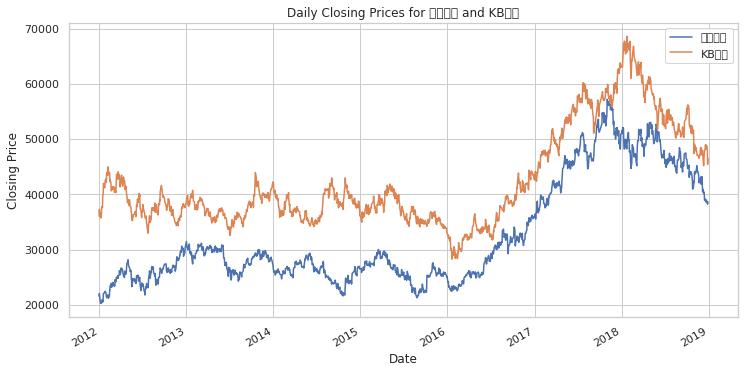

In [69]:
# 두 자산의 움직임을 시각화
ax = pair1[[asset1, asset2]].plot(figsize=(12, 6))
ax.set_title('Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
ax.grid(True)

### Calculate spread and ratio

In [70]:
# run OLS regression
model=sm.OLS(pair1.삼성전자, pair1.KB금융).fit()

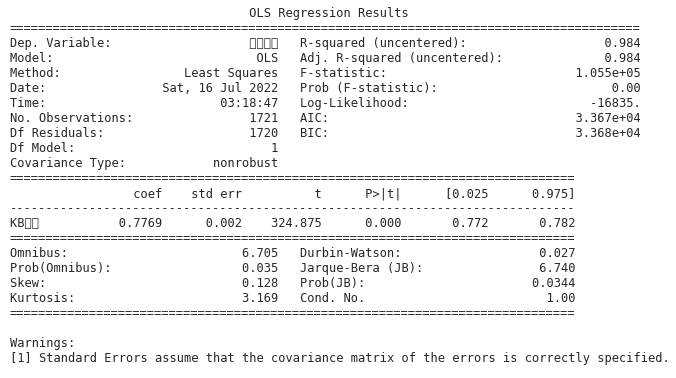

In [71]:
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)

In [72]:
# calculate spread
spread = pair1.삼성전자 - model.params[0] * pair1.KB금융

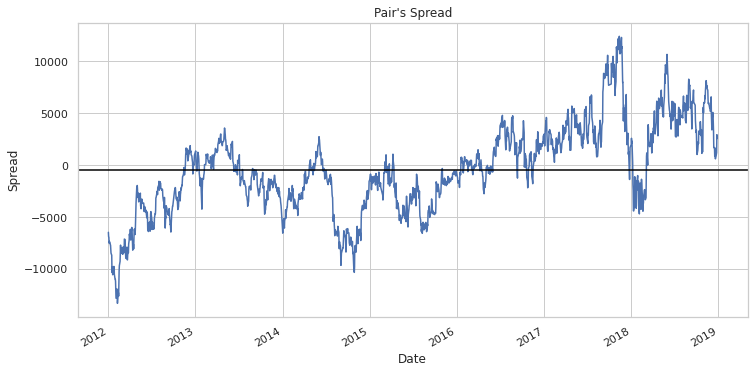

In [73]:
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.axhline(spread.mean(), color='black')
ax.set_ylabel("Spread")
ax.grid(True)

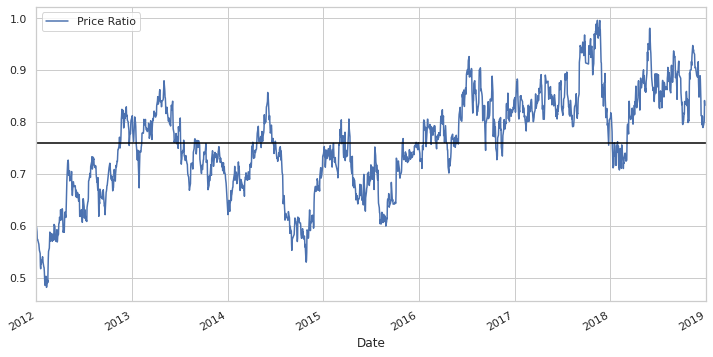

In [74]:
# Price ratio를 그리기
ratio = pair1.삼성전자 / pair1.KB금융
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim('2012-01-01', '2019-01-01')
plt.legend(['Price Ratio'])

In [75]:
# ADF test
adf = adfuller(spread, maxlag = 1)
print('Critical Value = ', adf[0])

Critical Value =  -3.559992955927844


## Generate Trading Signals using z-score

In [76]:
# calculate z-score
def zscore(series):
    return (series-series.mean()) / np.std(series)

In [77]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['삼성전자'] = train['삼성전자'] 
signals['KB금융'] = train['KB금융']
ratios = signals.삼성전자 / signals.KB금융

In [78]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = (np.mean(signals['z']) + np.std(signals['z'])) * 2
signals['z lower limit'] = (np.mean(signals['z']) - np.std(signals['z'])) * 2

In [79]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [80]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

In [81]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

,삼성전자,KB금융,z,z upper limit,z lower limit,signals1,positions1,signals2,positions2
Date,,,,,,,,,
2012-01-02,21600.0,36100.0,-1.678635,2.0,-2.0,0,NaN,0,NaN
2012-01-03,22100.0,37300.0,-1.739739,2.0,-2.0,0,0.0,0,0.0
2012-01-04,21600.0,36700.0,-1.780903,2.0,-2.0,0,0.0,0,0.0
2018-12-26,38350.0,47800.0,0.453708,2.0,-2.0,0,0.0,0,0.0
2018-12-27,38250.0,45450.0,0.864392,2.0,-2.0,0,0.0,0,0.0
2018-12-28,38700.0,46500.0,0.766892,2.0,-2.0,0,0.0,0,0.0


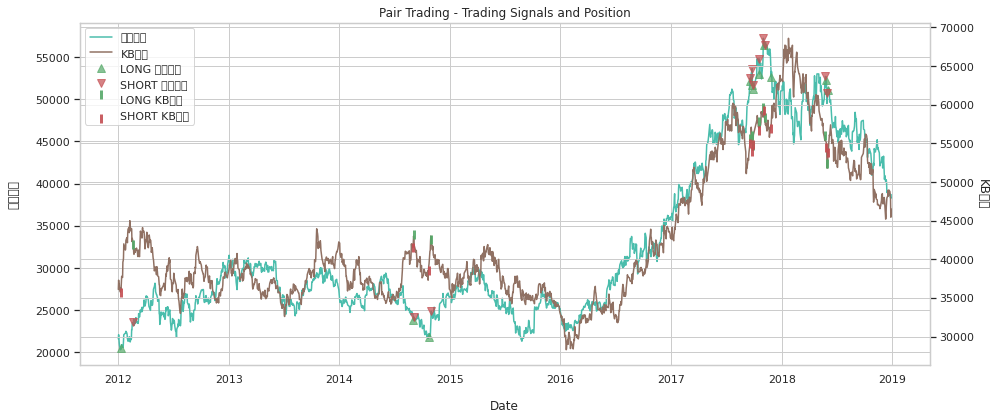

In [82]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['삼성전자'], c='#4abdac')
l2, = bx2.plot(signals['KB금융'], c='#907163')

u1, = bx.plot(signals['삼성전자'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['삼성전자'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['KB금융'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['KB금융'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('Date')
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format("삼성전자"),
           'SHORT {}'.format("삼성전자"),
           'LONG {}'.format("KB금융"),
           'SHORT {}'.format("KB금융")], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()

## Portfolio Profit and Loss Calculation

In [83]:
# initial capital to calculate the actual pnl
initial_capital = 1e8 / 2

# shares to buy for each position
positions1 = initial_capital// max(signals['삼성전자'])
positions2 = initial_capital// max(signals['KB금융'])

In [84]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['삼성전자'] = signals['삼성전자']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['삼성전자'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['삼성전자'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [85]:
portfolio['KB금융'] = signals['KB금융']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['KB금융'] * positions1
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['KB금융'] * positions1).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [86]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

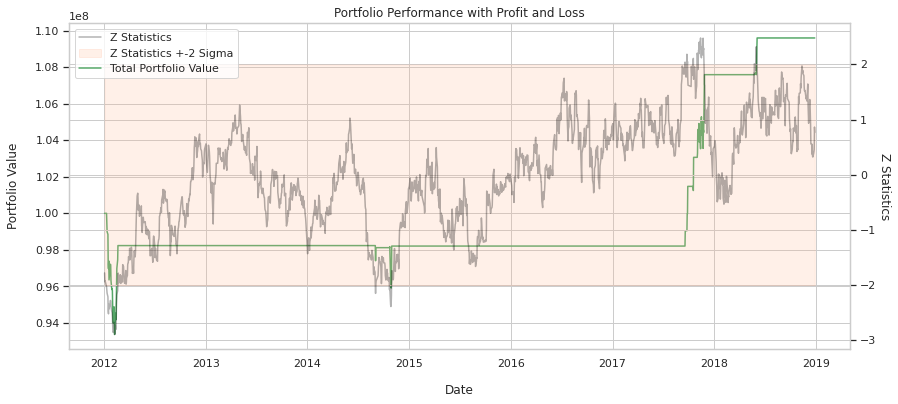

In [87]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-2 Sigma',
                      'Total Portfolio Value'],loc='upper left')

In [88]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
delta = (portfolio.index[-1] - portfolio.index[0]).days
print('Number of days = ', delta)

Number of days =  2550


In [89]:
YEAR_DAYS = 252
returns = (final_portfolio/(initial_capital*2)) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 0.909%


### Portfolio(All pairs)

In [90]:
def trade(S1, S2, bound, initial_capital, train_set=True):
    if train_set:
        signals = pd.DataFrame()
        signals[S1] = train[S1] 
        signals[S2] = train[S2]
    else:
        signals = pd.DataFrame()
        signals[S1] = test[S1]
        signals[S2] = test[S2]
        
    ratios = signals[S1] / signals[S2]
    signals['z'] = zscore(ratios)
    signals['z upper limit'] = (np.mean(signals['z']) + np.std(signals['z'])) * abs(bound)
    signals['z lower limit'] = (np.mean(signals['z']) - np.std(signals['z'])) * abs(bound)
    
    signals['signals1'] = 0
    signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)
    
    signals['positions1'] = signals['signals1'].diff()
    signals['signals2'] = -signals['signals1']
    signals['positions2'] = signals['signals2'].diff()
    
    # initial capital to calculate the actual pnl
    initial_capital = initial_capital/2

    # shares to buy for each position
    positions1 = initial_capital// max(signals[S1])
    positions2 = initial_capital// max(signals[S2])
    
    # since there are two assets, we calculate each asset Pnl separately 
    # and in the end we aggregate them into one portfolio
    portfolio = pd.DataFrame()
    portfolio[S1] = signals[S1]
    portfolio['holdings1'] = signals['positions1'].cumsum() * signals[S1] * positions1
    portfolio['cash1'] = initial_capital - (signals['positions1'] * signals[S1] * positions1).cumsum()
    portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
    portfolio['return1'] = portfolio['total asset1'].pct_change()
    portfolio['positions1'] = signals['positions1']
    
    portfolio[S2] = signals[S2]
    portfolio['holdings2'] = signals['positions2'].cumsum() * signals[S2] * positions1
    portfolio['cash2'] = initial_capital - (signals['positions2'] * signals[S2] * positions1).cumsum()
    portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
    portfolio['return2'] = portfolio['total asset2'].pct_change()
    portfolio['positions2'] = signals['positions2']
    
    # total pnl and z-score
    portfolio['z'] = signals['z']
    portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
    portfolio['z upper limit'] = signals['z upper limit']
    portfolio['z lower limit'] = signals['z lower limit']
    portfolio = portfolio.dropna()
    
    total_asset = portfolio['total asset']
    
    return total_asset

In [91]:
def pair_portfolio_return(pair_list, bound, initial_capital, train_set=True):
    capital = initial_capital/len(pair_list)
    if train_set:
        total_return = []
        for pair in pair_list:
            S1, S2 = pair[0], pair[1]
            pair_return = trade(S1, S2, bound, capital, train_set=True)
            total_return.append(pair_return)
        total_return = pd.DataFrame(np.array(total_return).squeeze().T).sum(axis=1)
        total_return.index = train.index[2:]
    else:
        total_return = []
        for pair in pair_list:
            S1, S2 = pair[0],pair[1]
            pair_return = trade(S1, S2, bound, capital, train_set=False)
            total_return.append(pair_return)
        total_return = pd.DataFrame(np.array(total_return).squeeze().T).sum(axis=1)
        total_return.index = test.index[2:]
    return total_return

In [92]:
total_df = pair_portfolio_return(pairs, 2, 1e10)

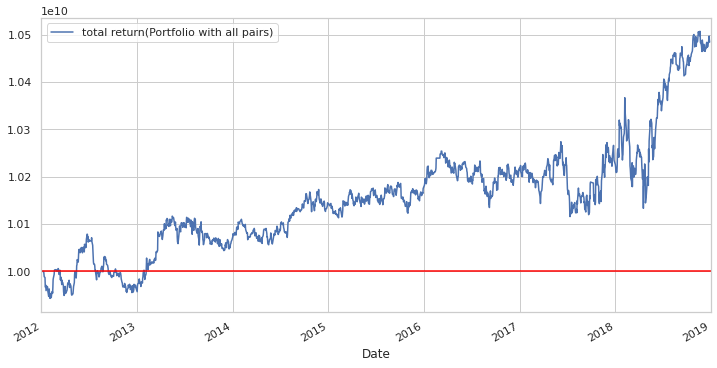

In [93]:
total_df.plot(figsize=(12,6))
plt.axhline(1e10, color='red')
plt.xlim('2012-01-01', '2019-01-01')
plt.legend(['total return(Portfolio with all pairs)'])

## Backtest

### Backtest1(2019~2021)

(737060.0, 737791.0)

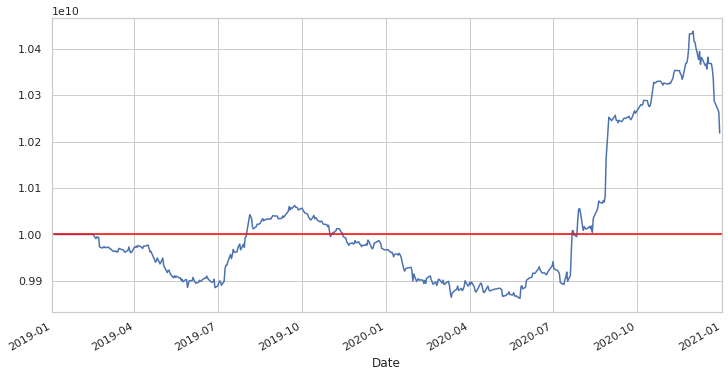

In [94]:
total_df = pair_portfolio_return(pairs, 2, 1e10, train_set=False)

total_df.plot(figsize=(12,6))
plt.axhline(1e10, color='red')
plt.xlim('2019-01-01', '2021-01-01')